In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
import numpy as np

# Model

In [3]:
X = tf.placeholder(tf.float32,shape=(None,28,28,1),name="Input_layer")

#capsules size

caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  
caps1_n_dims = 8


caps2_n_caps = 10 
caps2_n_dims = 16

# convolutional

conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

conv_1 = tf.layers.conv2d(X,**conv1_params)
conv_2 = tf.layers.conv2d(conv_1,**conv2_params)

# reshape to capsule
std = 0.1
capsule_input = tf.reshape(conv_2, [-1, caps1_n_caps, caps1_n_dims],name="caps1_raw")
capsule_input


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.


<tf.Tensor 'caps1_raw:0' shape=(?, 1152, 8) dtype=float32>

In [4]:
batch_size = tf.shape(X)[0]
weights = tf.random.normal(shape=(1,caps1_n_caps,caps2_n_caps,caps2_n_dims,caps1_n_dims),stddev=std,dtype=tf.float32)
# weights
w = tf.Variable(weights,name="W")

In [5]:
def squash(s,axis=-1,epsilon=1e-07,name=None):
  with tf.name_scope(name,default_name="squashing"):
    squared_norm = tf.reduce_sum(tf.square(s),axis=axis,keepdims=True)
    safe_norm = tf.sqrt(squared_norm + epsilon)
    unit_vector = s/safe_norm 
    return (squared_norm / 1+squared_norm)*unit_vector
capsule_1_squashed = squash(capsule_input,name="caps1_squash")
capsule_1_squashed

<tf.Tensor 'caps1_squash/mul:0' shape=(?, 1152, 8) dtype=float32>

In [6]:
weights_tiled = tf.tile(w,[batch_size,1,1,1,1],name="tiled_weights")
weights_tiled

<tf.Tensor 'tiled_weights:0' shape=(?, 1152, 10, 16, 8) dtype=float32>

In [7]:
capsule_1_tiled = tf.expand_dims(capsule_1_squashed,2)
capsule_1_tiled = tf.expand_dims(capsule_1_tiled,-1)
capsule_1_tiled = tf.tile(capsule_1_tiled,[1,1,caps2_n_caps,1,1],name="caps1_tiled")
capsule_1_tiled

<tf.Tensor 'caps1_tiled:0' shape=(?, 1152, 10, 8, 1) dtype=float32>

In [8]:
caps_2 = tf.matmul(weights_tiled,capsule_1_tiled,name="caps2_matmul")
caps_2 

<tf.Tensor 'caps2_matmul:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

In [9]:
b = tf.zeros(shape=(batch_size,caps1_n_caps,caps2_n_caps,1,1),dtype=tf.float32)
c = tf.nn.softmax(b,axis=2)
c

<tf.Tensor 'transpose_1:0' shape=(?, 1152, 10, 1, 1) dtype=float32>

In [10]:
caps_2_out =tf.multiply(caps_2,c,name="caps2_multiply")
caps_2_out

<tf.Tensor 'caps2_multiply:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

In [11]:
caps_2_squa = tf.reduce_sum(caps_2_out,axis=1,keep_dims=True,name="caps2_reduce_sum")
caps_2_squashed = squash(caps_2_squa,axis=-2,name="caps2_squash")
caps_2_squashed

Instructions for updating:
keep_dims is deprecated, use keepdims instead


<tf.Tensor 'caps2_squash/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [12]:
caps_2_tiled = tf.tile(caps_2_squashed,[1,caps1_n_caps,1,1,1],name="caps2_tile")
caps_2_tiled

<tf.Tensor 'caps2_tile:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

In [13]:
db = tf.matmul(caps_2,caps_2_tiled,transpose_a=True,name="multiply_vectors")
routing_2 = tf.add(b,db,name="add_b")
routing_weights_round_2 = tf.nn.softmax(routing_2,
                                        dim=2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps_2,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")
caps_2_squashed = caps2_output_round_2

Instructions for updating:
dim is deprecated, use axis instead


#Loss

In [14]:
def safenorm(s,axis=-1,epsilon=1e-07,name=None):
  with tf.name_scope(name,default_name="safe_norm"):
    return tf.sqrt(tf.reduce_sum(tf.square(s),axis=axis,keepdims=True))

m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

caps_out_norm = safenorm(caps_2_squashed,-2,name="norm")
y_pred = tf.argmax(caps_out_norm,2,name="prediction")
predicted = tf.squeeze(y_pred,axis=[1,2,3],name="squeezing")

y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

T = tf.one_hot(y,depth=caps2_n_caps,name="one_hot_encoding_T")

present_error = tf.reshape(tf.square(tf.maximum(0., m_plus - caps_out_norm),name="present_error"),shape=(-1,10))

absent_error = tf.reshape(tf.square(tf.maximum(0.,caps_out_norm-m_minus),name="absent_error"),shape=(-1,10))

L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,name="L")
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")


In [15]:
mask_with_labels = tf.placeholder_with_default(False, shape=(),name="mask_with_labels")
target = tf.cond(mask_with_labels,lambda:y,lambda:predicted)

target_one_hot = tf.one_hot(target,depth=caps2_n_caps,name="one_hot_encoding_target")
target_one_hot

<tf.Tensor 'one_hot_encoding_target:0' shape=(?, 10) dtype=float32>

In [16]:
caps_2_squashed

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [17]:
reshaped = tf.reshape(target_one_hot,[-1,1,caps2_n_caps,1,1],name="reshaped_target")
reshaped

<tf.Tensor 'reshaped_target:0' shape=(?, 1, 10, 1, 1) dtype=float32>

In [18]:
decoder_input = tf.multiply(caps_2_squashed,reshaped,name="decode_input")
decoder_input

<tf.Tensor 'decode_input:0' shape=(?, 1, 10, 16, 1) dtype=float32>

# Decoder

In [19]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28
reshape = tf.reshape(decoder_input,[-1,caps2_n_caps*caps2_n_dims])
layer = tf.layers.dense(reshape,n_hidden1,activation=tf.nn.relu,name="layer1")
layer = tf.layers.dense(layer,n_hidden2,activation=tf.nn.relu,name="layer2")
out = tf.layers.dense(layer,n_output,activation=tf.nn.relu,name="layer3")

X_flat = tf.reshape(X, [-1, n_output], name="X_flat")

loss = tf.square(X_flat-out,name="reconstruction_loss")
reconstraction_loss = tf.reduce_mean(loss,name="reconstruction_loss_mean")

Instructions for updating:
Use keras.layers.Dense instead.


In [20]:
loss

<tf.Tensor 'reconstruction_loss:0' shape=(?, 784) dtype=float32>

In [21]:
X_flat

<tf.Tensor 'X_flat:0' shape=(?, 784) dtype=float32>

In [22]:
out

<tf.Tensor 'layer3/Relu:0' shape=(?, 784) dtype=float32>

# Final loss

In [23]:
alpha = 0.0005
final_loss = tf.add(margin_loss,alpha*reconstraction_loss,name="final_loss")

# Accuarcy eval

In [24]:
acc = tf.equal(y,predicted,name="acc")
acc = tf.cast(acc,dtype=tf.float32,name="acc_cast")
acc

<tf.Tensor 'acc_cast:0' shape=(?,) dtype=float32>

In [25]:
accuarcy = tf.reduce_mean(acc,axis=0,name="acc_mean")
accuarcy

<tf.Tensor 'acc_mean:0' shape=() dtype=float32>

In [26]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(final_loss, name="training_op")
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [28]:
mnist.train.num_examples

55000

In [29]:
mnist.validation.num_examples

5000

In [30]:
n_epochs = 10
batch_size = 50
restore_checkpoint = True

n_iterations_per_epoch = mnist.train.num_examples // batch_size
n_iterations_validation = mnist.validation.num_examples // batch_size
best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, final_loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run(
                    [final_loss, accuarcy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Instructions for updating:
Use standard file APIs to check for files with this prefix.
Epoch: 1  Val accuracy: 96.3400%  Loss: 0.042574 (improved)
Epoch: 2  Val accuracy: 97.4200%  Loss: 0.031381 (improved)
Epoch: 3  Val accuracy: 97.9600%  Loss: 0.024746 (improved)
Epoch: 4  Val accuracy: 98.0200%  Loss: 0.023802 (improved)
Epoch: 5  Val accuracy: 98.3400%  Loss: 0.020857 (improved)
Epoch: 6  Val accuracy: 98.3600%  Loss: 0.021333
Epoch: 7  Val accuracy: 98.3600%  Loss: 0.020184 (improved)
Epoch: 8  Val accuracy: 98.4200%  Loss: 0.020276
Epoch: 9  Val accuracy: 98.6400%  Loss: 0.018113 (improved)
Epoch: 10  Val accuracy: 98.6800%  Loss: 0.017676 (improved)


INFO:tensorflow:Restoring parameters from ./my_capsule_network


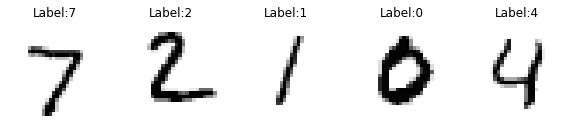

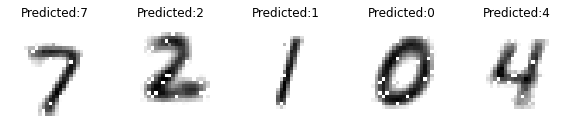

In [34]:
import matplotlib.pyplot as plt

n_samples = 5

sample_images = mnist.test.images[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    decoder_output_value, y_val = sess.run(
            [out, predicted],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})


sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(mnist.test.labels[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_val[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()